In [81]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
data = pd.read_csv('data/Big_Data.csv')
data = data.dropna()
data = data.drop(["Unnamed: 0"], axis = 1)
data = data.dropna()

In [100]:
# Logistic Regression on CHC and CCK

data = data[(data["classe_name"] == "CHC") | (data["classe_name"] == "CCK")]

X = data.drop(["classe_name"], axis = 1)
y = data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

logreg = LogisticRegression(class_weight={"CCK": 4, "CHC": 1}, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
#print confusion matrix
print(confusion_matrix(y_test, y_pred))

# Get the weights of the model in a dataframe
weights = logreg.coef_[0]
weights = pd.DataFrame(weights)
weights = weights.transpose()
weights.columns = X.columns
weights = weights.transpose()
weights.columns = ["weights"]
weights = weights.sort_values(by=['weights'], ascending=False)



Accuracy: 0.84
[[ 3  2]
 [ 2 18]]


<Axes: >

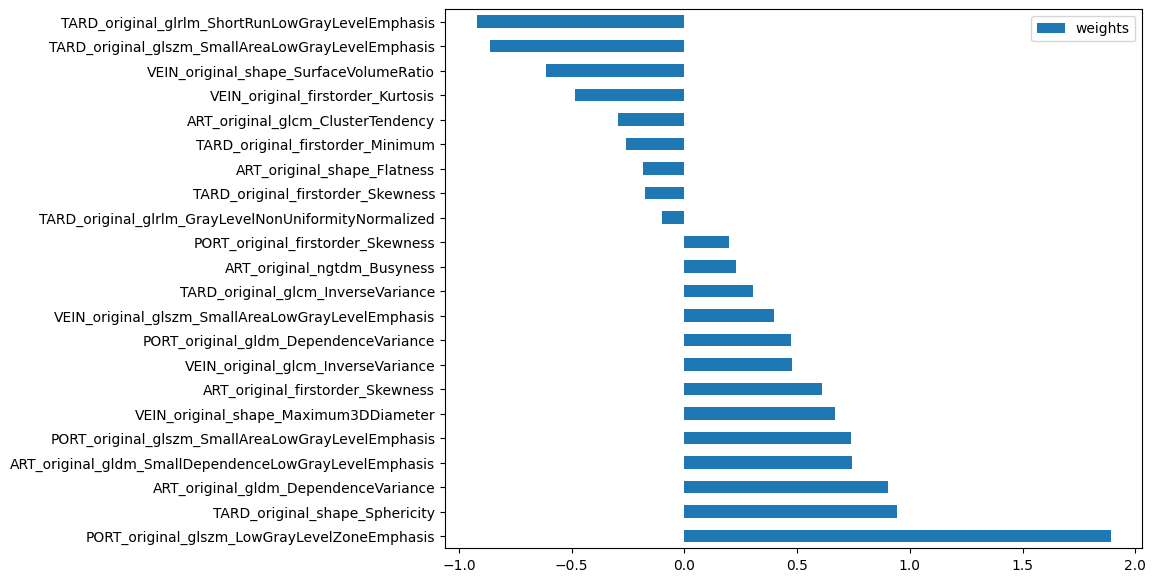

In [103]:
weights[np.abs(weights["weights"]) > 0.1].plot.barh(figsize=(9, 7))

From now on we will keep only those 17 variables

In [95]:
very_few_features_names = weights[np.abs(weights["weights"]) > 0.3].index.tolist()

few_data = data[very_few_features_names + ["classe_name"]]


In [96]:
# Retrain the model with the few features
X = few_data.drop(["classe_name"], axis = 1)
y = few_data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

logreg = LogisticRegression(class_weight={"CCK": 4, "CHC": 1})
logreg.fit(X_train, y_train)


LogisticRegression(class_weight={'CCK': 4, 'CHC': 1})

In [97]:
# Checking the variability of the coefficients

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
scores = cross_validate(logreg, X, y, cv=cv, n_jobs=2,return_estimator=True)

coefs = pd.DataFrame(
    [
        est.coef_[0] for est, (train_idx, _) in zip(scores["estimator"], cv.split(X, y))
    ],
    columns=very_few_features_names,
)

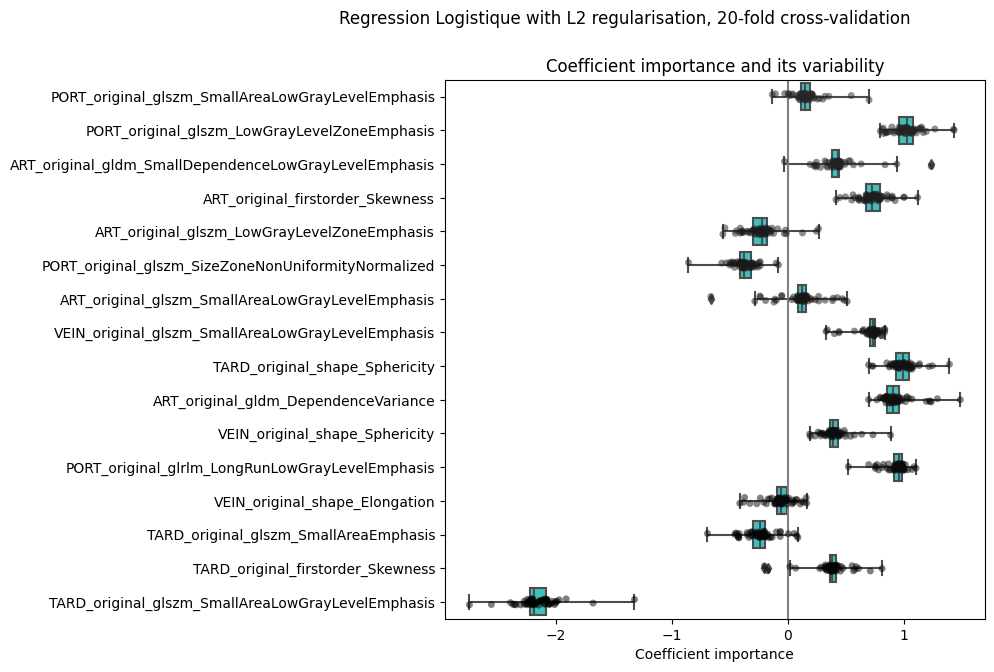

In [98]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Regression Logistique with L2 regularisation, 20-fold cross-validation")
plt.subplots_adjust(left=0.3)

Using statsmodel to do this analysis

In [93]:
very_few_features_names = weights[np.abs(weights["weights"]) > 0.3].index.tolist()

few_data = data[very_few_features_names + ["classe_name"]]

# Change CHC to 0 and CCK to 1
few_data["classe_name"] = few_data["classe_name"].replace(["CHC", "CCK"], [0, 1])

C:\Users\Fotis\AppData\Local\Temp\ipykernel_6988\2301382787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  few_data["classe_name"] = few_data["classe_name"].replace(["CHC", "CCK"], [0, 1])


In [94]:
import statsmodels.api as sm

X = few_data.drop(["classe_name"], axis = 1)
y = few_data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit_regularized(method="l1", alpha=0.1)
print(result.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.37497498317827377
            Iterations: 118
            Function evaluations: 118
            Gradient evaluations: 118
                                           Results: Logit
Model:                           Logit                         Method:                        MLE    
Dependent Variable:              classe_name                   Pseudo R-squared:              0.305  
Date:                            2023-05-30 21:05              AIC:                           66.8366
No. Observations:                57                            BIC:                           95.4393
Df Model:                        13                            Log-Likelihood:                -19.418
Df Residuals:                    43                            LL-Null:                       -27.960
Converged:                       1.0000                        LLR p-value:                   0.19556
No. Iterations